### 예측치와 가장 가까운 관측소간 RMSE 계산

In [296]:
import pandas as pd 
import numpy as np
from datetime import datetime, timedelta 
import os,re, json

script_directory = os.getcwd()
base_path = os.path.dirname(script_directory)

In [297]:
json_path = os.path.join(base_path, "target_metadata.json")
with open(json_path, 'r', encoding='utf-8') as f:
    target_metadata = json.load(f)

In [298]:
station_num = str(target_metadata.get("station_num"))
if not station_num:
    raise ValueError("target_metadata.json에서 station_num을 찾을 수 없습니다.")

In [299]:
station_num

'KG_0028'

In [300]:
target_date = target_metadata['target_date']  # 기준 날짜 (문자열)
target_datetime = datetime.strptime(target_date, "%Y%m%d%H")  # datetime 변환

In [301]:
forecast_file_path = os.path.join(base_path, "ENSEMBLE_MODEL_STATION_DATA")
obs_file_path = os.path.join(base_path, "OBS_DATA_UV")

In [302]:
forecast_files = [f for f in os.listdir(forecast_file_path) if f.endswith(".csv")]
obs_files = [f for f in os.listdir(obs_file_path) if f.endswith(".csv")]

In [303]:
forecast_files

['KG_0028_32.40_125.00_2025012000.csv',
 'KG_0028_32.40_125.00_2025012012.csv',
 'KG_0028_32.40_125.00_2025012100.csv',
 'KG_0028_32.40_125.00_2025012112.csv',
 'KG_0028_32.40_125.00_2025012200.csv',
 'KG_0028_32.40_125.00_2025012212.csv',
 'KG_0028_32.40_125.00_2025012300.csv',
 'KG_0028_32.40_125.00_2025012312.csv',
 'KG_0028_32.40_125.00_2025012400.csv',
 'KG_0028_32.40_125.00_2025012412.csv',
 'KG_0028_32.40_125.00_2025012500.csv',
 'KG_0028_32.40_125.00_2025012512.csv',
 'KG_0028_32.40_125.00_2025012600.csv',
 'KG_0028_32.40_125.00_2025012612.csv',
 'KG_0028_32.40_125.00_2025012700.csv',
 'KG_0028_32.40_125.00_2025012712.csv',
 'KG_0028_32.40_125.00_2025012800.csv',
 'KG_0028_32.40_125.00_2025012812.csv',
 'KG_0028_32.40_125.00_2025012900.csv',
 'KG_0028_32.40_125.00_2025012912.csv',
 'KG_0028_32.40_125.00_2025013000.csv',
 'KG_0028_32.40_125.10_2025012000.csv',
 'KG_0028_32.40_125.10_2025012012.csv',
 'KG_0028_32.40_125.10_2025012100.csv',
 'KG_0028_32.40_125.10_2025012112.csv',


In [304]:
from collections import defaultdict

def extract_station_id_forecast(file_name):
    """Forecast 파일에서 관측소 ID 추출"""
    parts = file_name.split("_")
    
    if parts[0].isdigit():  # 첫 번째 부분이 숫자라면 그대로 사용
        return parts[0]  # '22189_...' → '22189'
    
    elif len(parts) > 1 and parts[1].isdigit():  # 문자가 먼저 나오고 숫자가 있는 경우
        return parts[1]  # 'IE_0061_...' → '0061'
    
    return None  # 숫자가 없으면 None 반환

In [305]:
def extract_station_id_obs(file_name):
    """OBS 파일에서 관측소 ID 추출 (마지막 숫자)"""
    match = re.search(r'(\d+)(?=\.\w+$)', file_name)  # 확장자 앞의 숫자 찾기
    if match:
        return match.group(1)  # 'kma_buoy_22189.csv' → '22189'
    return None

In [306]:
forecast_mapping = defaultdict(list)
obs_mapping = {}

# ✅ Forecast 파일 매핑
for f in forecast_files:
    station_id = extract_station_id_forecast(f)
    if station_id:
        forecast_mapping[station_id].append(f)

# ✅ OBS 파일 매핑
for f in obs_files:
    station_id = extract_station_id_obs(f)
    if station_id:
        obs_mapping[station_id] = f

In [307]:
forecast_mapping

defaultdict(list,
            {'0028': ['KG_0028_32.40_125.00_2025012000.csv',
              'KG_0028_32.40_125.00_2025012012.csv',
              'KG_0028_32.40_125.00_2025012100.csv',
              'KG_0028_32.40_125.00_2025012112.csv',
              'KG_0028_32.40_125.00_2025012200.csv',
              'KG_0028_32.40_125.00_2025012212.csv',
              'KG_0028_32.40_125.00_2025012300.csv',
              'KG_0028_32.40_125.00_2025012312.csv',
              'KG_0028_32.40_125.00_2025012400.csv',
              'KG_0028_32.40_125.00_2025012412.csv',
              'KG_0028_32.40_125.00_2025012500.csv',
              'KG_0028_32.40_125.00_2025012512.csv',
              'KG_0028_32.40_125.00_2025012600.csv',
              'KG_0028_32.40_125.00_2025012612.csv',
              'KG_0028_32.40_125.00_2025012700.csv',
              'KG_0028_32.40_125.00_2025012712.csv',
              'KG_0028_32.40_125.00_2025012800.csv',
              'KG_0028_32.40_125.00_2025012812.csv',
              'KG_00

In [308]:
obs_mapping

{'0025': 'khoa_buoy_KG_0025.csv',
 '0028': 'khoa_buoy_KG_0028.csv',
 '0101': 'khoa_buoy_KG_0101.csv',
 '0102': 'khoa_buoy_KG_0102.csv',
 '0069': 'khoa_buoy_TW_0069.csv',
 '0081': 'khoa_buoy_TW_0081.csv',
 '0091': 'khoa_buoy_TW_0091.csv',
 '0093': 'khoa_buoy_TW_0093.csv',
 '0042': 'khoa_ostn_DT_0042.csv',
 '0060': 'khoa_sci_IE_0060.csv',
 '0061': 'khoa_sci_IE_0061.csv',
 '0062': 'khoa_sci_IE_0062.csv',
 '21229': 'kma_buoy_21229.csv',
 '22101': 'kma_buoy_22101.csv',
 '22103': 'kma_buoy_22103.csv',
 '22104': 'kma_buoy_22104.csv',
 '22105': 'kma_buoy_22105.csv',
 '22106': 'kma_buoy_22106.csv',
 '22107': 'kma_buoy_22107.csv',
 '22108': 'kma_buoy_22108.csv',
 '22183': 'kma_buoy_22183.csv',
 '22184': 'kma_buoy_22184.csv',
 '22187': 'kma_buoy_22187.csv',
 '22189': 'kma_buoy_22189.csv',
 '22190': 'kma_buoy_22190.csv',
 '22191': 'kma_buoy_22191.csv',
 '22297': 'kma_buoy_22297.csv',
 '22298': 'kma_buoy_22298.csv',
 '22299': 'kma_buoy_22299.csv',
 '22300': 'kma_buoy_22300.csv',
 '22302': 'kma_buoy

### 관측치 처리

In [309]:
station_num

'KG_0028'

In [310]:
station_num = station_num.split('_')[1]
# ✅ 타겟 관측소만 처리 (station_num이 존재하는지 확인)
if station_num not in forecast_mapping:
    raise ValueError(f"❌ 타겟 지점 {station_num}의 Forecast 데이터가 없습니다.")

if station_num not in obs_mapping:
    raise ValueError(f"❌ 타겟 지점 {station_num}의 OBS 데이터가 없습니다.")

# ✅ OBS 파일 경로 가져오기
obs_file = obs_mapping.get(station_num)  # 직접 키를 조회
if obs_file is None:
    raise ValueError(f"❌ OBS 데이터에서 {station_num}에 해당하는 파일을 찾을 수 없습니다.")

obs_file_path_full = os.path.join(obs_file_path, obs_file)

# ✅ 디버깅용 출력
print(f"📂 OBS 파일 경로: {obs_file_path_full}")


📂 OBS 파일 경로: d:\2025research\20250204\OBS_DATA_UV\khoa_buoy_KG_0028.csv


In [311]:
obs_file_path_full

'd:\\2025research\\20250204\\OBS_DATA_UV\\khoa_buoy_KG_0028.csv'

In [312]:
def round_time_nearest_hour(dt):
    return dt.replace(minute=0, second=0)

In [313]:
obs_file = obs_mapping[station_num]
obs_file_path_full = os.path.join(obs_file_path, obs_file)

if not os.path.exists(obs_file_path_full):
    raise FileNotFoundError(f"파일이 존재하지 않습니다: {obs_file_path_full}")

print(f"📂 타겟 관측소의 OBS 데이터 처리 중: {obs_file}")


📂 타겟 관측소의 OBS 데이터 처리 중: khoa_buoy_KG_0028.csv


In [314]:
obs_df = pd.read_csv(obs_file_path_full)

In [315]:
obs_df

model_fct  obs_ws  obs_wd     obs_u     obs_v
0    2025-01-05 00:00:00     1.9   339.0  0.680899 -1.773803
1    2025-01-05 01:00:00     1.5   343.0  0.438558 -1.434457
2    2025-01-05 02:00:00     1.5   177.0 -0.078504  1.497944
3    2025-01-05 03:00:00     1.2   107.0 -1.147566  0.350846
4    2025-01-05 04:00:00     0.6   135.0 -0.424264  0.424264
..                   ...     ...     ...       ...       ...
693  2025-02-02 21:00:00     9.7   325.0  5.563691 -7.945775
694  2025-02-02 22:00:00     9.9   324.0  5.819074 -8.009268
695  2025-02-02 23:00:00     9.3   325.0  5.334261 -7.618114
696  2025-02-03 00:00:00     9.0   320.0  5.785088 -6.894400
697  2025-02-03 01:00:00     9.2   317.0  6.274385 -6.728454

[698 rows x 5 columns]

In [316]:
obs_df["TIME"] = pd.to_datetime(obs_df["model_fct"], errors="coerce")
obs_df.set_index("TIME", inplace=True)
obs_df

model_fct  obs_ws  obs_wd     obs_u     obs_v
TIME                                                                        
2025-01-05 00:00:00  2025-01-05 00:00:00     1.9   339.0  0.680899 -1.773803
2025-01-05 01:00:00  2025-01-05 01:00:00     1.5   343.0  0.438558 -1.434457
2025-01-05 02:00:00  2025-01-05 02:00:00     1.5   177.0 -0.078504  1.497944
2025-01-05 03:00:00  2025-01-05 03:00:00     1.2   107.0 -1.147566  0.350846
2025-01-05 04:00:00  2025-01-05 04:00:00     0.6   135.0 -0.424264  0.424264
...                                  ...     ...     ...       ...       ...
2025-02-02 21:00:00  2025-02-02 21:00:00     9.7   325.0  5.563691 -7.945775
2025-02-02 22:00:00  2025-02-02 22:00:00     9.9   324.0  5.819074 -8.009268
2025-02-02 23:00:00  2025-02-02 23:00:00     9.3   325.0  5.334261 -7.618114
2025-02-03 00:00:00  2025-02-03 00:00:00     9.0   320.0  5.785088 -6.894400
2025-02-03 01:00:00  2025-02-03 01:00:00     9.2   317.0  6.274385 -6.728454

[698 rows x 5 columns]

In [317]:
obs_df = obs_df.resample("1H").asfreq()
obs_df

C:\Users\dasap\AppData\Local\Temp\ipykernel_28484\3394953962.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  obs_df = obs_df.resample("1H").asfreq()


model_fct  obs_ws  obs_wd     obs_u     obs_v
TIME                                                                        
2025-01-05 00:00:00  2025-01-05 00:00:00     1.9   339.0  0.680899 -1.773803
2025-01-05 01:00:00  2025-01-05 01:00:00     1.5   343.0  0.438558 -1.434457
2025-01-05 02:00:00  2025-01-05 02:00:00     1.5   177.0 -0.078504  1.497944
2025-01-05 03:00:00  2025-01-05 03:00:00     1.2   107.0 -1.147566  0.350846
2025-01-05 04:00:00  2025-01-05 04:00:00     0.6   135.0 -0.424264  0.424264
...                                  ...     ...     ...       ...       ...
2025-02-02 21:00:00  2025-02-02 21:00:00     9.7   325.0  5.563691 -7.945775
2025-02-02 22:00:00  2025-02-02 22:00:00     9.9   324.0  5.819074 -8.009268
2025-02-02 23:00:00  2025-02-02 23:00:00     9.3   325.0  5.334261 -7.618114
2025-02-03 00:00:00  2025-02-03 00:00:00     9.0   320.0  5.785088 -6.894400
2025-02-03 01:00:00  2025-02-03 01:00:00     9.2   317.0  6.274385 -6.728454

[698 rows x 5 columns]

In [318]:
obs_u_mean = obs_df["obs_u"].mean()
obs_v_mean = obs_df["obs_v"].mean()

obs_df["obs_u"] = obs_df["obs_u"].interpolate(method="linear").fillna(obs_u_mean)
obs_df["obs_v"] = obs_df["obs_v"].interpolate(method="linear").fillna(obs_v_mean)


In [319]:
obs_df

model_fct  obs_ws  obs_wd     obs_u     obs_v
TIME                                                                        
2025-01-05 00:00:00  2025-01-05 00:00:00     1.9   339.0  0.680899 -1.773803
2025-01-05 01:00:00  2025-01-05 01:00:00     1.5   343.0  0.438558 -1.434457
2025-01-05 02:00:00  2025-01-05 02:00:00     1.5   177.0 -0.078504  1.497944
2025-01-05 03:00:00  2025-01-05 03:00:00     1.2   107.0 -1.147566  0.350846
2025-01-05 04:00:00  2025-01-05 04:00:00     0.6   135.0 -0.424264  0.424264
...                                  ...     ...     ...       ...       ...
2025-02-02 21:00:00  2025-02-02 21:00:00     9.7   325.0  5.563691 -7.945775
2025-02-02 22:00:00  2025-02-02 22:00:00     9.9   324.0  5.819074 -8.009268
2025-02-02 23:00:00  2025-02-02 23:00:00     9.3   325.0  5.334261 -7.618114
2025-02-03 00:00:00  2025-02-03 00:00:00     9.0   320.0  5.785088 -6.894400
2025-02-03 01:00:00  2025-02-03 01:00:00     9.2   317.0  6.274385 -6.728454

[698 rows x 5 columns]

### 앙상블 예측 파일 처리

In [320]:
station_num = str(target_metadata.get("station_num")) # 잘렸을 수도 있어서

forecast_files = [f for f in os.listdir(forecast_file_path) if f.startswith(f"{station_num}_")]
forecast_files

['KG_0028_32.40_125.00_2025012000.csv',
 'KG_0028_32.40_125.00_2025012012.csv',
 'KG_0028_32.40_125.00_2025012100.csv',
 'KG_0028_32.40_125.00_2025012112.csv',
 'KG_0028_32.40_125.00_2025012200.csv',
 'KG_0028_32.40_125.00_2025012212.csv',
 'KG_0028_32.40_125.00_2025012300.csv',
 'KG_0028_32.40_125.00_2025012312.csv',
 'KG_0028_32.40_125.00_2025012400.csv',
 'KG_0028_32.40_125.00_2025012412.csv',
 'KG_0028_32.40_125.00_2025012500.csv',
 'KG_0028_32.40_125.00_2025012512.csv',
 'KG_0028_32.40_125.00_2025012600.csv',
 'KG_0028_32.40_125.00_2025012612.csv',
 'KG_0028_32.40_125.00_2025012700.csv',
 'KG_0028_32.40_125.00_2025012712.csv',
 'KG_0028_32.40_125.00_2025012800.csv',
 'KG_0028_32.40_125.00_2025012812.csv',
 'KG_0028_32.40_125.00_2025012900.csv',
 'KG_0028_32.40_125.00_2025012912.csv',
 'KG_0028_32.40_125.00_2025013000.csv',
 'KG_0028_32.40_125.10_2025012000.csv',
 'KG_0028_32.40_125.10_2025012012.csv',
 'KG_0028_32.40_125.10_2025012100.csv',
 'KG_0028_32.40_125.10_2025012112.csv',


In [321]:
df_list = (pd.read_csv(os.path.join(forecast_file_path, file)).assign(SOURCE_FILE=file) for file in forecast_files)
combined_df = pd.concat(df_list, ignore_index=True)

In [322]:
combined_df

TIME  UGRD_10maboveground  VGRD_10maboveground  \
0       2025-01-20 00:00:00             3.704649            -6.067770   
1       2025-01-20 02:59:12             3.500380            -6.015373   
2       2025-01-20 06:00:32             5.115825            -5.924464   
3       2025-01-20 08:59:44             5.428569            -5.652524   
4       2025-01-20 12:01:04             3.612476            -6.396767   
...                     ...                  ...                  ...   
436795  2025-02-01 12:01:04            -2.577040            -5.254018   
436796  2025-02-01 15:00:16            -0.223511            -3.780316   
436797  2025-02-01 17:59:28            -1.570834            -8.577523   
436798  2025-02-01 21:00:48            -1.192828            -4.777678   
436799  2025-02-02 00:00:00            -1.017357            -4.433875   

         STN_NO   LAT    LON  LAT_I  LON_J  \
0       KG_0028  32.4  125.0      0      0   
1       KG_0028  32.4  125.0      0      0   
2       KG_0028  32.4  125.0      0      0   
3       KG_0028  32.4  125.0      0      0   
4       KG_0028  32.4  125.0      0      0   
...         ...   ...    ...    ...    ...   
436795  KG_0028  34.9  128.1     25     31   
436796  KG_0028  34.9  128.1     25     31   
436797  KG_0028  34.9  128.1     25     31   
436798  KG_0028  34.9  128.1     25     31   
436799  KG_0028  34.9  128.1     25     31   

                                SOURCE_FILE  
0       KG_0028_32.40_125.00_2025012000.csv  
1       KG_0028_32.40_125.00_2025012000.csv  
2       KG_0028_32.40_125.00_2025012000.csv  
3       KG_0028_32.40_125.00_2025012000.csv  
4       KG_0028_32.40_125.00_2025012000.csv  
...                                     ...  
436795  KG_0028_34.90_128.10_2025013000.csv  
436796  KG_0028_34.90_128.10_2025013000.csv  
436797  KG_0028_34.90_128.10_2025013000.csv  
436798  KG_0028_34.90_128.10_2025013000.csv  
436799  KG_0028_34.90_128.10_2025013000.csv  

[436800 rows x 9 columns]

### RMSE 계산

In [323]:
# ✅ obs_df의 현재 구조 확인
print("📊 obs_df의 현재 Index:", obs_df.index)

# ✅ obs_df가 이미 TIME을 Index로 가지고 있다면 컬럼으로 변환
if isinstance(obs_df.index, pd.DatetimeIndex):  
    obs_df = obs_df.reset_index()  # Index를 컬럼으로 변환
    print("✅ obs_df의 TIME을 컬럼으로 변환 완료!")

# ✅ 변환 후 데이터 확인
print(obs_df.head())


📊 obs_df의 현재 Index: DatetimeIndex(['2025-01-05 00:00:00', '2025-01-05 01:00:00',
               '2025-01-05 02:00:00', '2025-01-05 03:00:00',
               '2025-01-05 04:00:00', '2025-01-05 05:00:00',
               '2025-01-05 06:00:00', '2025-01-05 07:00:00',
               '2025-01-05 08:00:00', '2025-01-05 09:00:00',
               ...
               '2025-02-02 16:00:00', '2025-02-02 17:00:00',
               '2025-02-02 18:00:00', '2025-02-02 19:00:00',
               '2025-02-02 20:00:00', '2025-02-02 21:00:00',
               '2025-02-02 22:00:00', '2025-02-02 23:00:00',
               '2025-02-03 00:00:00', '2025-02-03 01:00:00'],
              dtype='datetime64[ns]', name='TIME', length=698, freq='h')
✅ obs_df의 TIME을 컬럼으로 변환 완료!
                 TIME            model_fct  obs_ws  obs_wd     obs_u     obs_v
0 2025-01-05 00:00:00  2025-01-05 00:00:00     1.9   339.0  0.680899 -1.773803
1 2025-01-05 01:00:00  2025-01-05 01:00:00     1.5   343.0  0.438558 -1.434457
2 2025-01-05

In [324]:
import pandas as pd
import numpy as np
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")

# ✅ obs_df가 이미 TIME을 Index로 가지고 있다면 컬럼으로 변환
if isinstance(obs_df.index, pd.DatetimeIndex):  
    obs_df = obs_df.reset_index()
    print("✅ obs_df의 TIME을 컬럼으로 변환 완료!")

# ✅ Forecast CSV들을 전부 불러서 하나로 합침
all_forecast_dfs = []
for forecast_file in forecast_files:
    forecast_path = os.path.join(forecast_file_path, forecast_file)
    df_fcst = pd.read_csv(forecast_path)

    # TIME 컬럼을 datetime 형식으로 변환
    df_fcst["TIME"] = pd.to_datetime(df_fcst["TIME"], errors="coerce")

    # ✅ 가장 가까운 정시(1시간 단위)로 변환
    df_fcst["TIME"] = df_fcst["TIME"].dt.round("H")

    df_fcst["SOURCE_FILE"] = forecast_file  # 원본 파일 정보 추가
    all_forecast_dfs.append(df_fcst)

# ✅ 하나의 DataFrame으로 병합
df_forecast = pd.concat(all_forecast_dfs, ignore_index=True)

# ✅ 병합: TIME 기준으로 OBS 값 유지
df_merged = pd.merge(df_forecast, obs_df, on="TIME", how="left")


# ✅ 최종 정리된 데이터 개수 확인
print(f"📊 정리된 데이터 개수: {len(df_merged)} 개")
print(df_merged.head(3))


✅ Using device: cuda


C:\Users\dasap\AppData\Local\Temp\ipykernel_28484\3452308010.py:23: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_fcst["TIME"] = df_fcst["TIME"].dt.round("H")
C:\Users\dasap\AppData\Local\Temp\ipykernel_28484\3452308010.py:23: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_fcst["TIME"] = df_fcst["TIME"].dt.round("H")
C:\Users\dasap\AppData\Local\Temp\ipykernel_28484\3452308010.py:23: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_fcst["TIME"] = df_fcst["TIME"].dt.round("H")
C:\Users\dasap\AppData\Local\Temp\ipykernel_28484\3452308010.py:23: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_fcst["TIME"] = df_fcst["TIME"].dt.round("H")
C:\Users\dasap\AppData\Local\Temp\ipykernel_28484\3452308010.py:23: FutureWarning: 'H' is deprecated and will be removed in a future ver

📊 정리된 데이터 개수: 436800 개
                 TIME  UGRD_10maboveground  VGRD_10maboveground   STN_NO  \
0 2025-01-20 00:00:00             3.704649            -6.067770  KG_0028   
1 2025-01-20 03:00:00             3.500380            -6.015373  KG_0028   
2 2025-01-20 06:00:00             5.115825            -5.924464  KG_0028   

    LAT    LON  LAT_I  LON_J                          SOURCE_FILE  \
0  32.4  125.0      0      0  KG_0028_32.40_125.00_2025012000.csv   
1  32.4  125.0      0      0  KG_0028_32.40_125.00_2025012000.csv   
2  32.4  125.0      0      0  KG_0028_32.40_125.00_2025012000.csv   

             model_fct  obs_ws  obs_wd     obs_u     obs_v  
0  2025-01-20 00:00:00     5.2   278.0  5.149394 -0.723700  
1  2025-01-20 03:00:00     5.9   289.0  5.578560 -1.920852  
2  2025-01-20 06:00:00     7.0   293.0  6.443534 -2.735118  


In [325]:
df_merged.to_csv('forecast_df.csv')

In [326]:
import torch

if torch.cuda.is_available():
    print(f"✅ GPU 사용 가능: {torch.cuda.get_device_name(0)}")
    print(f"✅ 현재 GPU 메모리 사용량: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
else:
    print("⚠️ GPU를 사용할 수 없습니다.")


✅ GPU 사용 가능: NVIDIA GeForce RTX 3090
✅ 현재 GPU 메모리 사용량: 10.70 MB


In [327]:
df_merged.head()

TIME  UGRD_10maboveground  VGRD_10maboveground   STN_NO  \
0 2025-01-20 00:00:00             3.704649            -6.067770  KG_0028   
1 2025-01-20 03:00:00             3.500380            -6.015373  KG_0028   
2 2025-01-20 06:00:00             5.115825            -5.924464  KG_0028   
3 2025-01-20 09:00:00             5.428569            -5.652524  KG_0028   
4 2025-01-20 12:00:00             3.612476            -6.396767  KG_0028   

    LAT    LON  LAT_I  LON_J                          SOURCE_FILE  \
0  32.4  125.0      0      0  KG_0028_32.40_125.00_2025012000.csv   
1  32.4  125.0      0      0  KG_0028_32.40_125.00_2025012000.csv   
2  32.4  125.0      0      0  KG_0028_32.40_125.00_2025012000.csv   
3  32.4  125.0      0      0  KG_0028_32.40_125.00_2025012000.csv   
4  32.4  125.0      0      0  KG_0028_32.40_125.00_2025012000.csv   

             model_fct  obs_ws  obs_wd     obs_u     obs_v  
0  2025-01-20 00:00:00     5.2   278.0  5.149394 -0.723700  
1  2025-01-20 03:00:00     5.9   289.0  5.578560 -1.920852  
2  2025-01-20 06:00:00     7.0   293.0  6.443534 -2.735118  
3  2025-01-20 09:00:00     6.4   305.0  5.242573 -3.670889  
4  2025-01-20 12:00:00     6.1   308.0  4.806866 -3.755535

In [328]:
import torch
import numpy as np

# ✅ GPU 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")

# ✅ 필요한 열을 GPU로 변환
forecast_tensor = torch.tensor(df_merged[["UGRD_10maboveground", "VGRD_10maboveground"]].values, dtype=torch.float32, device=device)
obs_tensor = torch.tensor(df_merged[["obs_u", "obs_v"]].values, dtype=torch.float32, device=device)

# ✅ MSE 및 RMSE 계산 (U, V 성분을 개별적으로 더함)
mse = torch.sum((forecast_tensor - obs_tensor) ** 2, dim=1)  # ✅ 2로 나누지 않고 합산
rmse = torch.sqrt(mse)  # RMSE 계산

# ✅ RMSE를 DataFrame에 추가
df_merged["RMSE"] = rmse.cpu().numpy()  # GPU → CPU 변환 후 저장


✅ Using device: cuda


In [329]:
df_merged["RMSE"].tail(50)

436750     5.607470
436751     7.053126
436752     6.275222
436753     8.127707
436754     3.709859
436755     2.800616
436756     2.939735
436757     1.006014
436758     0.798096
436759     2.561315
436760     2.530463
436761     3.437855
436762     4.028866
436763     3.645640
436764     3.637057
436765     4.164579
436766     8.263825
436767     9.139865
436768     5.883365
436769     6.509773
436770    10.148223
436771     9.699376
436772     7.901711
436773    11.351409
436774     8.788553
436775     4.568894
436776     2.780704
436777     3.115668
436778     1.162133
436779     0.626098
436780     0.772077
436781     1.877961
436782     3.455920
436783     3.307561
436784     2.909234
436785     3.428009
436786     5.753803
436787     7.647711
436788     9.335583
436789     9.060459
436790     8.942807
436791    10.551538
436792     8.793309
436793     5.598918
436794     5.337466
436795     9.127191
436796     9.163254
436797     3.920254
436798     5.737132
436799     2.069862


In [330]:
rmse_values = [[] for _ in range(25)]  # 0~24 구간 (총 25개)

# ✅ 인덱스를 기반으로 25개 그룹으로 RMSE 저장
for idx, row in df_merged.iterrows():
    group_idx = idx % 25  # 0~24 순환 (0, 1, ..., 24 → 25개 그룹)
    rmse_values[group_idx].append(row["RMSE"])  # 해당 그룹에 RMSE 값 추가

# ✅ 결과 출력
for i in range(25):
    if rmse_values[i]:
        print(f"⏳ {i*3}시간 후 예측 RMSE 평균: {np.mean(rmse_values[i]):.4f}")
    else:
        print(f"⏳ {i*3}시간 후 예측 RMSE 데이터 없음")


⏳ 0시간 후 예측 RMSE 평균: 4.5099
⏳ 3시간 후 예측 RMSE 평균: 4.0392
⏳ 6시간 후 예측 RMSE 평균: 4.2680
⏳ 9시간 후 예측 RMSE 평균: 4.3123
⏳ 12시간 후 예측 RMSE 평균: 4.3233
⏳ 15시간 후 예측 RMSE 평균: 4.0190
⏳ 18시간 후 예측 RMSE 평균: 4.2737
⏳ 21시간 후 예측 RMSE 평균: 4.3408
⏳ 24시간 후 예측 RMSE 평균: 4.3625
⏳ 27시간 후 예측 RMSE 평균: 4.1981
⏳ 30시간 후 예측 RMSE 평균: 4.2534
⏳ 33시간 후 예측 RMSE 평균: 4.3376
⏳ 36시간 후 예측 RMSE 평균: 4.2382
⏳ 39시간 후 예측 RMSE 평균: 4.0260
⏳ 42시간 후 예측 RMSE 평균: 4.2352
⏳ 45시간 후 예측 RMSE 평균: 4.2892
⏳ 48시간 후 예측 RMSE 평균: 4.3165
⏳ 51시간 후 예측 RMSE 평균: 4.1429
⏳ 54시간 후 예측 RMSE 평균: 4.5683
⏳ 57시간 후 예측 RMSE 평균: 4.8812
⏳ 60시간 후 예측 RMSE 평균: 4.3462
⏳ 63시간 후 예측 RMSE 평균: 4.2478
⏳ 66시간 후 예측 RMSE 평균: 4.6849
⏳ 69시간 후 예측 RMSE 평균: 4.6048
⏳ 72시간 후 예측 RMSE 평균: 4.3174


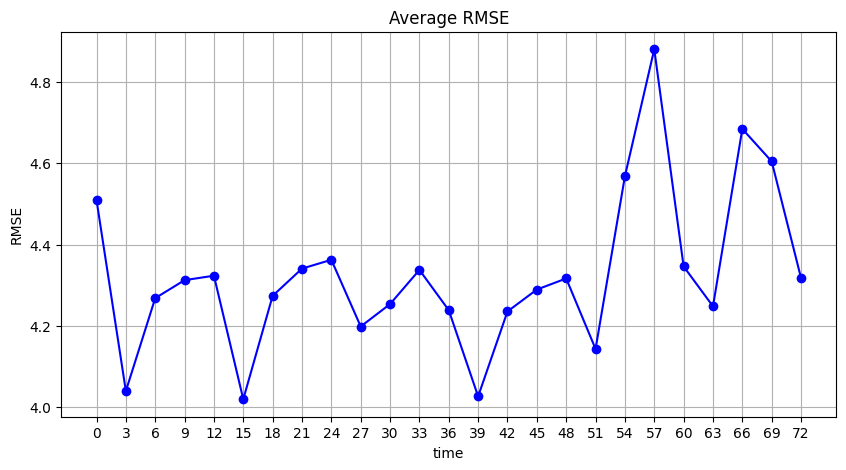

In [331]:
import matplotlib.pyplot as plt

# x축: 각 그룹에 해당하는 시간 (0, 3, 6, ... 72 시간)
x = [i * 3 for i in range(25)]

# y축: 각 그룹의 평균 RMSE (데이터가 없는 경우 None)
y = [np.mean(rmse_values[i]) if rmse_values[i] else None for i in range(25)]

plt.figure(figsize=(10, 5))
plt.plot(x, y, marker='o', linestyle='-', color='b')
plt.xlabel("time")
plt.ylabel("RMSE")
plt.title("Average RMSE")
plt.grid(True)
plt.xticks(x)  # x축 눈금 표시
plt.show()
